In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
import plotly.graph_objects as go
import animatplot as amp
plt.style.use(["science", "notebook", "grid", "dark_background"])

In [2]:
class SigMoidOptimiser:
    def __init__(self, xtrue, ytrue) -> None:
        self.xtrue = xtrue
        self.w, self.b = np.random.uniform(-6, 6,  size=2)
        self.ytrue = ytrue
        self.yhat = self.calc_sigmoid(self.xtrue, self.w, self.b)
    
    @staticmethod
    def calc_sigmoid(x, w, b):
        return 1.0 / (1.0 + np.exp(-(w * x - b)))

    def loss(self, w, b):
        preds = self.calc_sigmoid(self.xtrue, w, b)
        return 0.5 * np.sum((preds - self.ytrue) ** 2)
    
    
    def grad_w(self, w, b, x, y):
        fx = self.calc_sigmoid(x, w, b)
        return (fx - y) * fx * (1 - fx) * x
    
    def grad_b(self, w, b, x, y):
        fx = self.calc_sigmoid(x, w, b)
        return (fx - y) * fx * (1 - fx)

    @staticmethod
    def calculate_lookahead_gradient(x, ytrue, w, b, v_w, v_b, lr, gamma):
        w_lookahead = w - gamma * v_w
        b_lookahead = b - gamma * v_b
        yhat = SigMoidOptimiser.calc_sigmoid(x, w_lookahead, b_lookahead)
        dw_lookahead = np.sum((yhat - ytrue) * yhat * (1 - yhat) * x)
        db_lookahead = np.sum((yhat - ytrue) * yhat * (1 - yhat))
        return dw_lookahead, db_lookahead

    def do_vanilla_gradient_descent(self, lr=0.02, epochs=100, starting_point = (-4, -4)):
        """Does vanilla gradient descent
        Args:
            lr (float, optional): Learning rate. Defaults to 0.02.
            epochs (int, optional): Number of epochs. Defaults to 100.
            starting_point (tuple, optional): (w0, b0) Starting point for the optimisation. 
                                                Defaults to (-4, -4).
        Returns:
            np.array: Losses through the epochs
            np.array: ws through the epochs
            np.array: bs through the epochs"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        for idx in range(epochs):
            dw, db = 0.0, 0.0
            for x, y in zip(self.xtrue, self.ytrue):
                dw += self.grad_w(self.w, self.b, x, y)
                db += self.grad_b(self.w, self.b, x, y)
            self.w -= lr * dw # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= lr * db # Update the b value
            bs[idx] = self.b # Append the new b value
            self.losses[idx] = self.loss(self.w, self.b) # Calculate the new loss
        return self.losses, ws, bs
    
    def do_momentum_gradient_descent(self, lr = 0.02, epochs = 100, gamma = 0.9, starting_point = (-4, -4)):
        """Does momentum gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0. # Initialising the velocity
        
        for idx in range(epochs):
            dw, db = self.calc_gradient()

            # Look at the history of the gradients
            v_w = gamma * v_w + lr * dw
            v_b = gamma * b_w + lr * db

            self.w -= v_w # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= v_b # Update the b value
            bs[idx] = self.b # Append the new b value

            # Calculate the new predictions and loss
            self.yhat = self.calc_sigmoid(self.xtrue, self.w, self.b)
            self.losses[idx] = self.loss()
        return self.losses, ws, bs
    
    def do_nesterov_accelerated_gradient_descent(self, lr = 0.02, epochs = 100, gamma = 0.9, starting_point = (-4, -4)):
        """Does nested momentum gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0.

        for idx in range(epochs):
            dw_lookahead, db_lookahead = self.calculate_lookahead_gradient(self.xtrue, self.ytrue, self.w, self.b, v_w, b_w, lr, gamma)

            v_w = gamma * v_w + lr * dw_lookahead
            v_b = gamma * b_w + lr * db_lookahead

            self.w -= v_w
            ws[idx] = self.w

            self.b -= v_b
            bs[idx] = self.b

            self.yhat = self.calc_sigmoid(self.xtrue, self.w, self.b)
            self.losses[idx] = self.loss()

        return self.losses, ws, bs

    def trace_path(self, xtrue, y_pts, color, label, ax):
        ax.plot(xtrue, y_pts, "o--", color=color, label = label, linewidth = 0.5, markersize = 1)
        ax.scatter(xtrue[0], y_pts[0], color = color, s = 200, marker = "p")
        ax.scatter(xtrue[-1], y_pts[-1], color = color, s = 200, marker = "x")
        ax.legend()

    def plot_loss_landscape(self, fig, ax):
        w_values = np.linspace(-10, 10, 200)  # Example range for w
        b_values = np.linspace(-10, 10, 200)  # Example range for b
        W, B = np.meshgrid(w_values, b_values)

        # Calculate predictions and MSE loss for each w, b pair
        loss_matrix = np.zeros(W.shape)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j]
                b = B[i, j]
                mse_loss = self.loss(w, b)  # Calculate MSE loss for this w, b
                loss_matrix[i, j] = mse_loss

        cax = ax.contourf(W, B, loss_matrix, levels=20, cmap="coolwarm")
        ax.set_xlabel(r"w $\rightarrow$", fontsize = 15, fontweight = "bold")
        ax.set_ylabel(r"b $\rightarrow$", fontsize = 15, fontweight = "bold")
        ax.set_title("Loss landscape", fontsize = 20, fontweight = "bold")
        fig.colorbar(cax, ax=ax, orientation="vertical", label = "Loss")
        return loss_matrix, w_values, b_values

In [3]:
xtrue = np.array([0.5, 2.5])
ytrue = np.array([0.2, 0.9])

sig = SigMoidOptimiser(xtrue, ytrue)

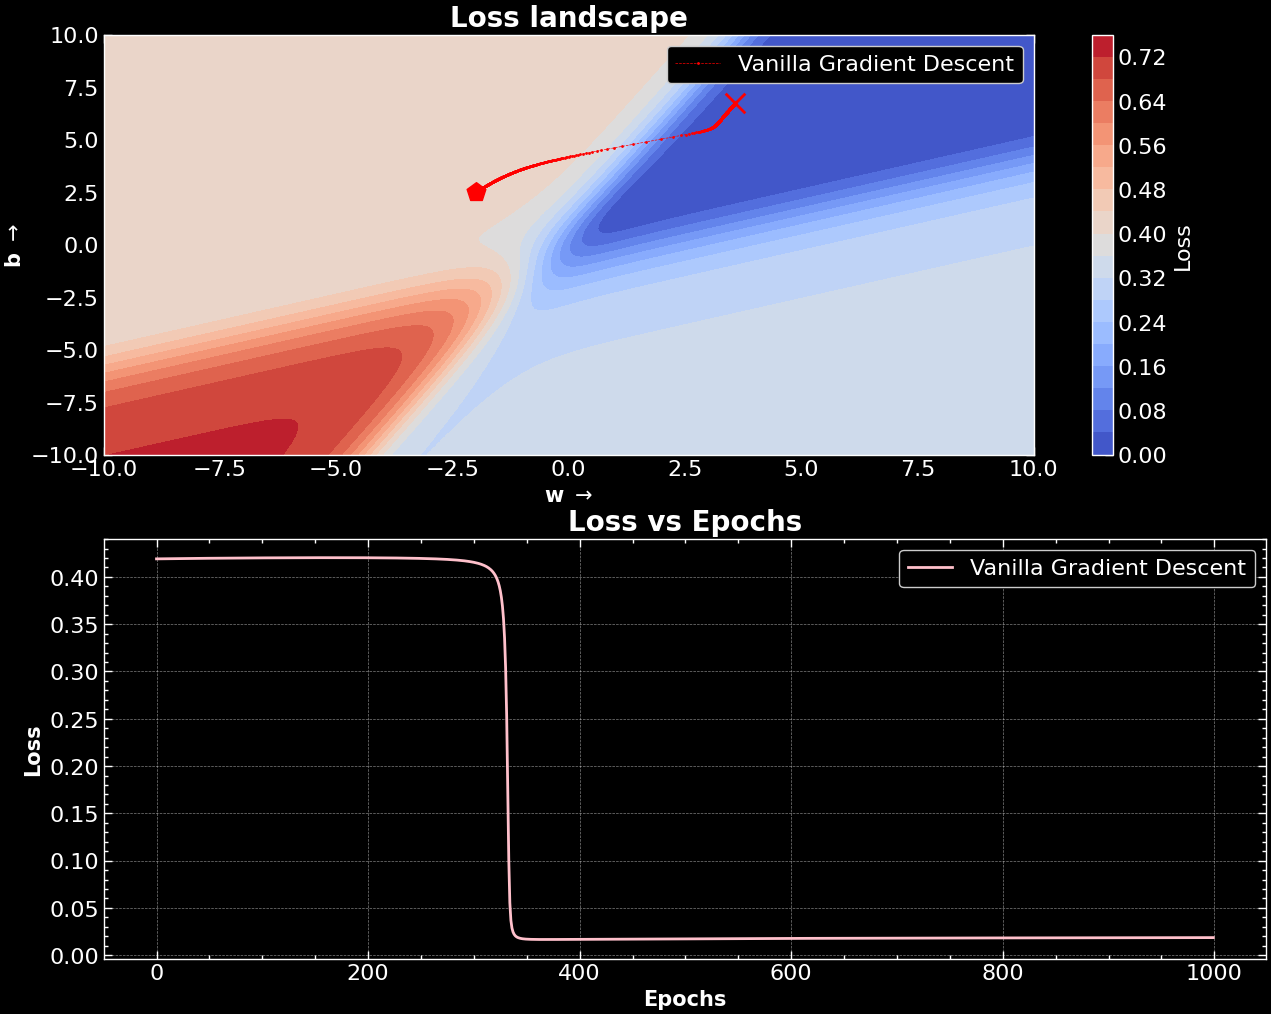

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
ax1, ax2 = ax.ravel()


loss_matrix, w_vals, b_vals = sig.plot_loss_landscape(fig, ax1)
losses_VGD, ws_VGD, bs_VGD = sig.do_vanilla_gradient_descent(lr = 1.0, epochs = 1000, starting_point=(-2, 2.5))
# losses_MGD, ws_MGD, bs_MGD = sig.do_momentum_gradient_descent(lr = 0.02, epochs = 10000, gamma = 0.5, starting_point=(-4, 4))
# losses_NMGD, ws_NMGD, bs_NMGD = sig.do_nesterov_accelerated_gradient_descent(lr = 0.02, epochs = 1000, gamma = 0.5)

sig.trace_path(ws_VGD, bs_VGD, "red", "Vanilla Gradient Descent", ax1)

# sig.trace_path(ws_MGD, bs_MGD, "red", "Momentum Gradient Descent", fig, ax1)
# sig.trace_path(ws_NMGD, bs_NMGD, "green", "NAG", fig, ax1)


ax2.plot(losses_VGD, label = "Vanilla Gradient Descent", color = "pink")
# ax2.plot(losses_MGD, label = "Momentum Gradient Descent", color = "red")
# ax2.plot(losses_NMGD, label = "NAG", color = "green")
ax2.set_xlabel("Epochs", fontsize = 15, fontweight = "bold")
ax2.set_ylabel("Loss", fontsize = 15, fontweight = "bold")
ax2.set_title("Loss vs Epochs", fontsize = 20, fontweight = "bold")
ax2.legend()

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\Confpc12\AppData\Local\Temp\ipykernel_3772\3627738108.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(ws_VGD[frame_end], bs_VGD[frame_end])


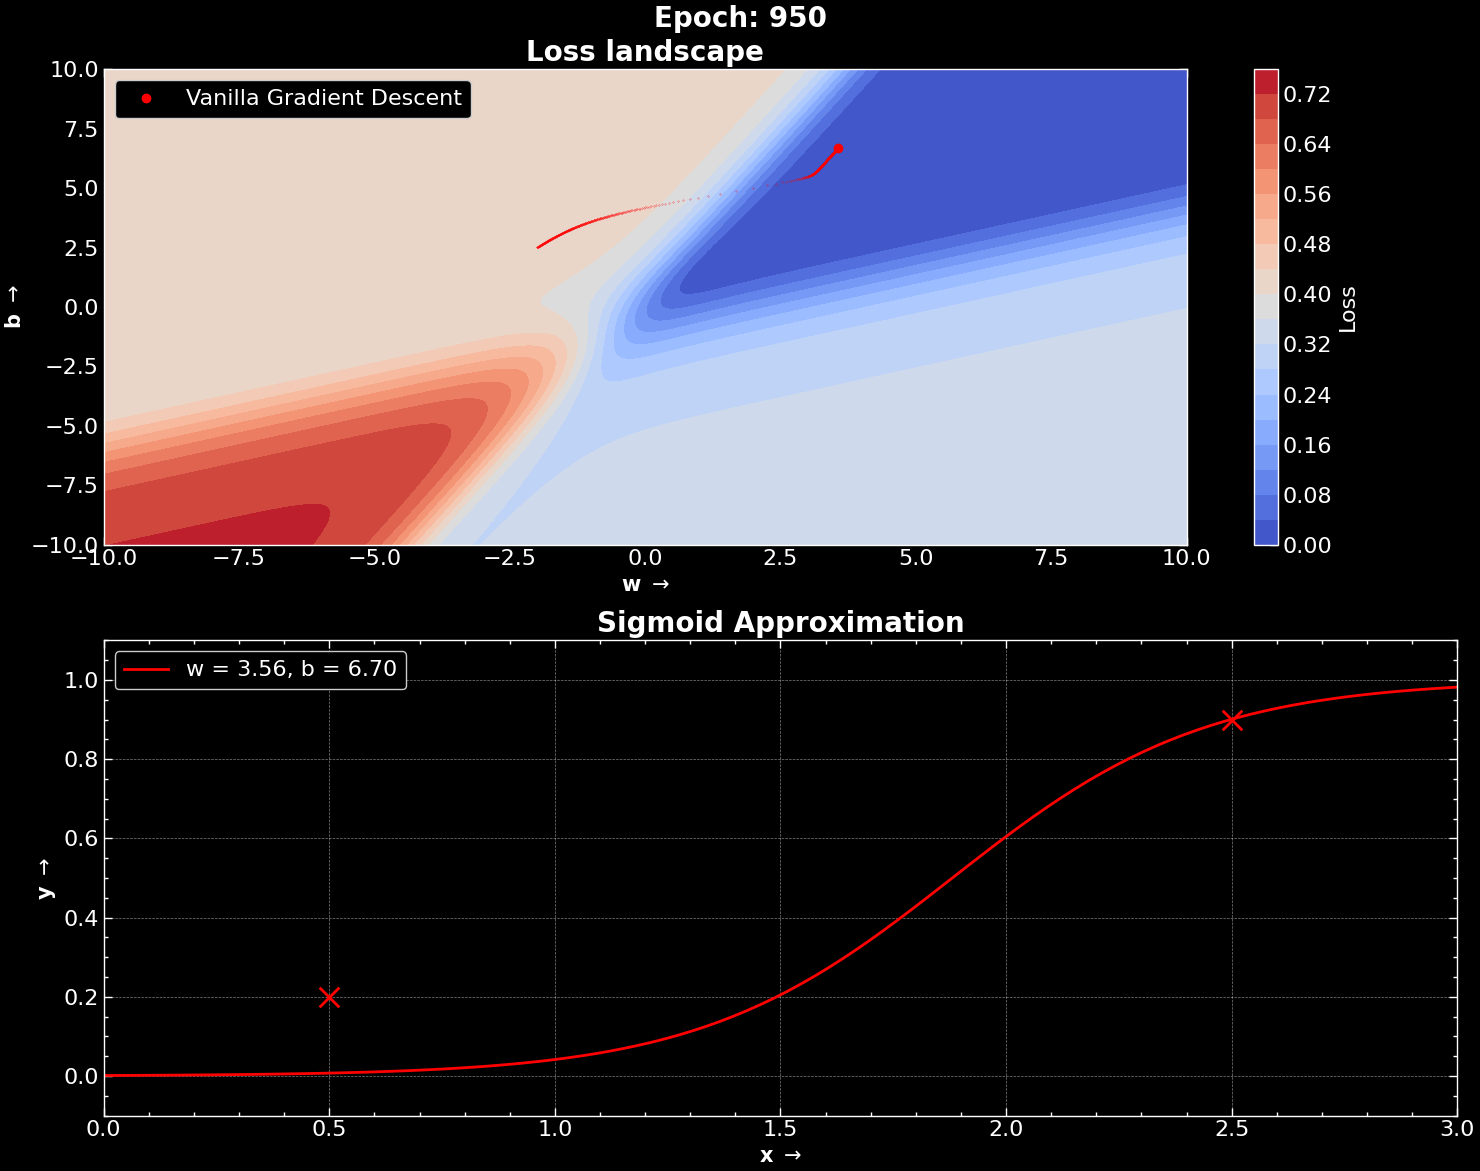

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

ax1, ax2 = ax.ravel()
ax2.set_xlim(0, 3)
ax2.set_ylim(-0.1, 1.1)
ax2.set_title("Sigmoid Approximation", fontsize = 20, fontweight = "bold")
ax2.set_xlabel(r"x $\rightarrow$", fontsize = 15, fontweight = "bold")
ax2.set_ylabel(r"y $\rightarrow$", fontsize = 15, fontweight = "bold")
ax2.scatter(xtrue, ytrue, color = "red", s = 200, marker = "x")

loss_matrix, w_vals, b_vals = sig.plot_loss_landscape(fig, ax1)
losses_VGD, ws_VGD, bs_VGD = sig.do_vanilla_gradient_descent(lr = 1.0, epochs = 1000, starting_point=(-2, 2.5))

line, = ax1.plot([], [], "ro", markersize = 0.2)
line2, = ax2.plot([], [], "r-", markersize = 0.2,  label = f"w = {ws_VGD[0]:.2f}, b = {bs_VGD[0]:.2f}")
point, = ax1.plot([], [], "ro",  label = "Vanilla Gradient Descent")
ax1.legend(loc = "upper left")

desired_frames = 300
skip_rate = len(ws_VGD) // desired_frames

suptitle = fig.suptitle('Epoch: 0', fontsize = 20, fontweight = "bold")

def init():
    line.set_data([], [])
    line2.set_data([], [])
    point.set_data([], [])
    suptitle.set_text('Epoch: 0')
    return line, point

xfit = np.linspace(0, 3, 100)
def animate(i):
    frame_end = skip_rate * i
    w, b = ws_VGD[frame_end], bs_VGD[frame_end]
    y_pts = sig.calc_sigmoid(xfit, w, b)
    line.set_data(ws_VGD[:frame_end], bs_VGD[:frame_end])
    line2.set_data(xfit, y_pts)
    point.set_data(ws_VGD[frame_end], bs_VGD[frame_end])
    suptitle.set_text(f'Epoch: {frame_end}')
    ax2.legend(loc = "upper left").texts[0].set_text(f'w = {w:.2f}, b = {b:.2f}')
    return line, point

plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=desired_frames, init_func=init, blit=True)
ani.save("vanilla_gradient_descent.gif", writer="imagemagick", fps=30)